# CW + Diversity Regularization on CIFAR10

In [15]:
import torch
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

import pickle
import datetime
import glob
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('precision', 10)

# custom code imports
from models import *
from neuron_coverage import *

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

device = torch.device("cpu")
if torch.cuda.is_available():
    print('CUDA is available!')
    device = torch.device("cuda")
else:
    print('CUDA is not available...')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CUDA is available!


# Load Data

In [16]:
data_dir = 'C:\data\MNIST'

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

if not os.path.exists(data_dir):
    os.makedirs(data_dir)

batch_size = 100 # determines how many of each class we want

def get_same_index(targets, label):
    '''
    Returns indices corresponding to the target label
    which the dataloader uses to serve downstream.
    '''
    label_indices = []
    for i in range(len(targets)):
        if targets[i] == label:
            label_indices.append(i)
    return label_indices


dataset = torchvision.datasets.MNIST(root=data_dir, 
                                     train=False, 
                                     download=True,
                                     transform=transforms.Compose([
                                         transforms.ToTensor()
                                     ]))

test_loader = torch.utils.data.DataLoader(dataset,
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          pin_memory=True)

## Generate per class batches for NC evaluation

In [17]:
# data = []
# labels = []

# for i in range(len(classes)):
    
#     target_indices = get_same_index(dataset.targets, i)
    
#     test_loader = torch.utils.data.DataLoader(dataset,
#         batch_size=batch_size, 
#         sampler=torch.utils.data.sampler.SubsetRandomSampler(target_indices),
#         shuffle=False,
#         num_workers=2, 
#         pin_memory=True)
    
#     inputs, targets = next(iter(test_loader))
    
#     data.append(inputs)
#     labels.append(targets)
    
# # torch.Size([10, batch_size, 1, 28, 28])
# inputs = torch.stack(data).to(device)

# # torch.Size([new_batch_size, 1, 28, 28])
# new_batch_size = len(classes) * batch_size
# all_inputs = inputs.view(new_batch_size,1,28,28)

# # torch.Size([10, batch_size])
# targets = torch.stack(labels).to(device)

# # torch.Size([new_batch_size])
# all_targets = targets.view(-1)

In [18]:
# # confirm that all the images are still intact after reshaping the tensor view
# orig_inputs = all_inputs.clone().cpu().detach().numpy()
# for img in orig_inputs:
#     plt.imshow(np.transpose(np.squeeze(img), (1, 2, 0))) 
#     plt.show()

# Train or Load Pretrained Model if available

In [19]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 100
learning_rate = 0.01
momentum = 0.5

random_seed = 1
torch.manual_seed(random_seed)

In [20]:
retrain = False
track_low_high = False

model = ConvNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# check to see if we can just load a previous model
# %mkdir models
latest_model = None
m_type = model.__class__.__name__
prev_models = glob.glob('pretrained_models/mnist/*'+ m_type +'*.pth')
if prev_models:
    latest_model = max(prev_models, key=os.path.getctime)

if (retrain is False 
    and latest_model is not None 
    and m_type in latest_model):  
    print('loading model', latest_model)
    model.load_state_dict(torch.load(latest_model))  
else:
    if track_low_high:
        model.init_dict(model.lowhigh_dict, inputs, 'relu', {'low': 0, 'high': 0})
        try:
            for epoch in range(1, n_epochs + 1):
                model.hook_lowhigh_dict('relu')
                train(model, device, train_loader, optimizer, epoch)
                model.remove_hooks()
                test(model, device, test_loader)    
        finally:
            model.remove_hooks()   
    else:
        for epoch in range(1, n_epochs + 1):
            train(model, device, train_loader, optimizer, epoch)
            acc = test(model, device, test_loader)  
    torch.save(model.state_dict(), 'pretrained_models/mnist/model_' + m_type + '_' + str(datetime.datetime.now()).replace(':','.') + '_' + str(acc) + '.pth')

loading model pretrained_models/mnist\model_ConvNet_2019-07-25 16.16.26.580052_98.82.pth


## Evaluate per class and overall accuracy

In [78]:
def get_acc(model, device, test_loader, sampler=False, class_idx=None, classes=None):
    # model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    if sampler:
        if class_idx is None:
            raise Exception('you must provide an integer class index if sampler=True')
        if classes is None:
            raise Exception('you must provide an iterable of class indices if sampler=True')
        values, counts = np.unique(test_loader.dataset.targets, return_counts=True) 
        divisor = counts[class_idx]
        acc = 100. * correct / divisor
        print(classes[class_idx] + '\t accuracy: {}/{} ({:.2f}%)'.format(correct, divisor, acc))
    else:
        divisor = len(test_loader.dataset)
        acc = 100. * correct / divisor
        print('accuracy: {}/{} ({:.2f}%)'.format(correct, divisor, acc))

In [81]:
# evaluate on total test set
get_acc(model, device, test_loader)

accuracy: 9882/10000 (98.82%)


In [60]:
# evaluate on each class separately534+
for i in range(len(classes)):
    
    target_indices = get_same_index(dataset.targets, i)
    
    test_loader = torch.utils.data.DataLoader(dataset,
        batch_size=batch_size, 
        sampler=SubsetRandomSampler(target_indices),
        shuffle=False,
        pin_memory=True)
    
    get_acc(model, device, test_loader, sampler=True, class_idx=i, classes=classes)

0	 accuracy: 976/980 (99.59%)
1	 accuracy: 1131/1135 (99.65%)
2	 accuracy: 1021/1032 (98.93%)
3	 accuracy: 994/1010 (98.42%)
4	 accuracy: 980/982 (99.80%)
5	 accuracy: 882/892 (98.88%)
6	 accuracy: 950/958 (99.16%)
7	 accuracy: 1004/1028 (97.67%)
8	 accuracy: 961/974 (98.67%)
9	 accuracy: 983/1009 (97.42%)


# Evaluating Neuron Coverage Per Class

In [24]:
nc_thresholds = np.arange(0,1,0.1)

neuron_coverages_by_class = {}

for i in range(len(classes)):
    
    threshold_results = {}
    
    for t in nc_thresholds:
        
        t = round(t,2)

        covered_neurons, total_neurons, neuron_coverage = eval_nc(model, inputs[i], t)
        print(classes[i] + ' neuron_coverage_' + str(t), neuron_coverage)

        threshold_results[str(t)] = neuron_coverage
    
    neuron_coverages_by_class[classes[i]] = threshold_results


0 neuron_coverage_0.0 0.8260755336617406



0 neuron_coverage_0.1 0.26157635467980295



0 neuron_coverage_0.2 0.14870279146141216



0 neuron_coverage_0.3 0.09507389162561576



0 neuron_coverage_0.4 0.06505747126436781



0 neuron_coverage_0.5 0.043645320197044334



0 neuron_coverage_0.6 0.026502463054187193



0 neuron_coverage_0.7 0.011264367816091954



0 neuron_coverage_0.8 0.002988505747126437



0 neuron_coverage_0.9 0.0012151067323481117



1 neuron_coverage_0.0 0.7785878489326765



1 neuron_coverage_0.1 0.15261083743842366



1 neuron_coverage_0.2 0.07678160919540229



1 neuron_coverage_0.3 0.044696223316912975



1 neuron_coverage_0.4 0.03070607553366174



1 neuron_coverage_0.5 0.021510673234811165



1 neuron_coverage_0.6 0.015008210180623973



1 neuron_coverage_0.7 0.00916256157635468



1 neuron_coverage_0.8 0.004499178981937603



1 neuron_coverage_0.9 0.001477832512315271



2 neuron_coverage_0.0 0.8783251231527094



2 neuron_coverage_0.1 0.29628899835796385



2 neuron_coverage_0.2 0.1631527093596059



2 neuron_coverage_0.3 0.09536945812807882



2 neuron_coverage_0.4 0.05921182266009852



2 neuron_coverage_0.5 0.03760262725779967



2 neuron_coverage_0.6 0.020853858784893268



2 neuron_coverage_0.7 0.009753694581280788



2 neuron_coverage_0.8 0.003645320197044335



2 neuron_coverage_0.9 0.001477832512315271



3 neuron_coverage_0.0 0.8488669950738916



3 neuron_coverage_0.1 0.2514614121510673



3 neuron_coverage_0.2 0.1335960591133005



3 neuron_coverage_0.3 0.07885057471264367



3 neuron_coverage_0.4 0.051527093596059115



3 neuron_coverage_0.5 0.032742200328407224



3 neuron_coverage_0.6 0.02006568144499179



3 neuron_coverage_0.7 0.00889983579638752



3 neuron_coverage_0.8 0.003513957307060755



3 neuron_coverage_0.9 0.0012151067323481117



4 neuron_coverage_0.0 0.8455500821018063



4 neuron_coverage_0.1 0.24292282430213466



4 neuron_coverage_0.2 0.13885057471264367



4 neuron_coverage_0.3 0.08660098522167488



4 neuron_coverage_0.4 0.05376026272577997



4 neuron_coverage_0.5 0.03201970443349754



4 neuron_coverage_0.6 0.01658456486042693



4 neuron_coverage_0.7 0.007783251231527093



4 neuron_coverage_0.8 0.0027914614121510675



4 neuron_coverage_0.9 0.001083743842364532



5 neuron_coverage_0.0 0.8804269293924466



5 neuron_coverage_0.1 0.3189819376026273



5 neuron_coverage_0.2 0.16788177339901478



5 neuron_coverage_0.3 0.09694581280788177



5 neuron_coverage_0.4 0.05750410509031199



5 neuron_coverage_0.5 0.03536945812807882



5 neuron_coverage_0.6 0.019737274220032842



5 neuron_coverage_0.7 0.009688013136288998



5 neuron_coverage_0.8 0.004170771756978654



5 neuron_coverage_0.9 0.0017405582922824302



6 neuron_coverage_0.0 0.8383251231527094



6 neuron_coverage_0.1 0.2277504105090312



6 neuron_coverage_0.2 0.11950738916256158



6 neuron_coverage_0.3 0.07155993431855501



6 neuron_coverage_0.4 0.04883415435139573



6 neuron_coverage_0.5 0.030377668308702793



6 neuron_coverage_0.6 0.015665024630541872



6 neuron_coverage_0.7 0.007257799671592775



6 neuron_coverage_0.8 0.0031198686371100163



6 neuron_coverage_0.9 0.0009523809523809524



7 neuron_coverage_0.0 0.8157635467980295



7 neuron_coverage_0.1 0.23921182266009852



7 neuron_coverage_0.2 0.13142857142857142



7 neuron_coverage_0.3 0.08154351395730706



7 neuron_coverage_0.4 0.0535632183908046



7 neuron_coverage_0.5 0.03431855500821018



7 neuron_coverage_0.6 0.02059113300492611



7 neuron_coverage_0.7 0.010410509031198686



7 neuron_coverage_0.8 0.004958949096880131



7 neuron_coverage_0.9 0.0019376026272577996



8 neuron_coverage_0.0 0.8508045977011495



8 neuron_coverage_0.1 0.2880131362889984



8 neuron_coverage_0.2 0.16417077175697867



8 neuron_coverage_0.3 0.10617405582922824



8 neuron_coverage_0.4 0.07123152709359606



8 neuron_coverage_0.5 0.04417077175697865



8 neuron_coverage_0.6 0.024926108374384238



8 neuron_coverage_0.7 0.009885057471264367



8 neuron_coverage_0.8 0.0037766830870279147



8 neuron_coverage_0.9 0.0012151067323481117



9 neuron_coverage_0.0 0.8094581280788178



9 neuron_coverage_0.1 0.22768472906403942



9 neuron_coverage_0.2 0.1316912972085386



9 neuron_coverage_0.3 0.08407224958949097



9 neuron_coverage_0.4 0.05422003284072249



9 neuron_coverage_0.5 0.03300492610837438



9 neuron_coverage_0.6 0.018555008210180624



9 neuron_coverage_0.7 0.008177339901477832



9 neuron_coverage_0.8 0.0031855500821018064



9 neuron_coverage_0.9 0.000689655172413793


In [25]:
save_file_path = "assets/neuron_coverages_mnist_10.pkl"
pickle.dump(neuron_coverages_by_class, open(save_file_path, "wb")) 

In [27]:
df = pd.DataFrame.from_dict(neuron_coverages_by_class)
df.to_clipboard(excel=True)

## Create Extreme Case Inputs

In [46]:
input_shape = (batch_size, 1, 28, 28)
all_blacks = torch.zeros(input_shape).to(device)
all_whites = torch.ones(input_shape).to(device)

In [47]:
covered_neurons, total_neurons, neuron_coverage = eval_nc(model, all_blacks, 0.0)
print('all_blacks neuron_coverage', neuron_coverage)

covered_neurons, total_neurons, neuron_coverage = eval_nc(model, all_whites, 0.0)
print('all_whites neuron_coverage', neuron_coverage)


all_blacks neuron_coverage 0.6136945812807881



all_whites neuron_coverage 0.6794417077175697


# Evaluating Effect of Increasing Neuron Coverage

In [61]:
# load the results from file
with open('assets/results.pickle', 'rb') as handle:
    results = pickle.load(handle)

In [12]:
inputs, targets = next(iter(test_loader))

inputs = inputs.to(device)
targets = targets.to(device)

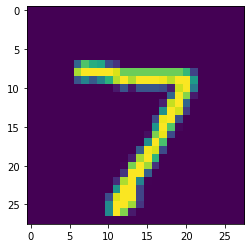

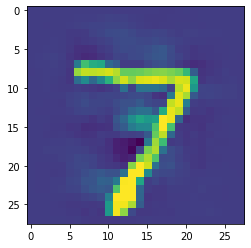

In [13]:
np_inputs = inputs.clone().cpu().detach().numpy()
np_advers = results[0]['adversaries'].clone().cpu().detach().numpy()

i = 0

plt.imshow(np.squeeze(np_inputs[i]))
plt.show()   

plt.imshow(np.squeeze(np_advers[i]))
plt.show()   

# Seeing if increasing neuron coverage effects the adversarial class

In [2]:
# load the results from file
with open('assets/results_mnist2019.08.17.pickle', 'rb') as handle:
    results = pickle.load(handle)

In [8]:
df = pd.DataFrame.from_dict(results)
target_features = ['attack', 
                   'layer', 
                   'regularization_weight', 
                   'orig_acc', 
                   'pert_acc', 
                   'neuron_coverage_000',
                   'neuron_coverage_020',
                   'neuron_coverage_050',
                   'neuron_coverage_075']
df[target_features]

,attack,layer,regularization_weight,orig_acc,pert_acc,neuron_coverage_000,neuron_coverage_020,neuron_coverage_050,neuron_coverage_075
0,cw_div4_attack,relu1-1,0,1.0,0.0,0.9482758621,0.2372742200,0.0660098522,0.0109688013
1,cw_div4_attack,relu1-1,1,1.0,0.0,0.9482101806,0.2371428571,0.0661412151,0.0110344828
2,cw_div4_attack,relu1-1,10,1.0,0.0,0.9483415435,0.2372742200,0.0665353038,0.0113628900
3,cw_div4_attack,relu1-1,100,1.0,0.0,0.9484072250,0.2376683087,0.0665353038,0.0113628900
4,cw_div4_attack,relu1-1,1000,1.0,0.0,0.9476190476,0.2418719212,0.0683087028,0.0120525452
5,cw_div4_attack,relu1-1,10000,1.0,0.0,0.9391461412,0.3030541872,0.0781609195,0.0137602627
6,cw_div4_attack,relu2-3,0,1.0,0.0,0.9483415435,0.2371428571,0.0664039409,0.0111658456
7,cw_div4_attack,relu2-3,1,1.0,0.0,0.9483415435,0.2369458128,0.0659441708,0.0109031199
8,cw_div4_attack,relu2-3,10,1.0,0.0,0.9480131363,0.2369458128,0.0661412151,0.0111001642
9,cw_div4_attack,relu2-3,100,1.0,0.0,0.9483415435,0.2368801314,0.0662725780,0.0111658456


## Logits Changes

In [132]:
logits_changes = []
# _, orig_counts = targets.unique(return_counts=True)
for result in results:
    pert_output = model(result['adversaries'])
    orig_output = model(inputs)
    # pert_pred = torch.argmax(pert_output, dim=1)
    # _, advs_counts = pert_pred.unique(return_counts=True)
    # class_changes.append(orig_counts)
    # class_changes.append(advs_counts)
    logits_changes.append((pert_output.sum(dim=0).int() - orig_output.sum(dim=0).int()).tolist())

In [133]:
normalized_logits_changes = []
for row in logits_changes:
    row_sum = sum(row)
    row = [round(x / row_sum, 3) for x in row]
    normalized_logits_changes.append(row)

In [134]:
normalized_logits_changes

[[0.089, 0.083, 0.092, 0.113, 0.098, 0.109, 0.105, 0.082, 0.112, 0.117],
 [0.089, 0.083, 0.092, 0.113, 0.098, 0.109, 0.105, 0.082, 0.112, 0.117],
 [0.088, 0.083, 0.093, 0.114, 0.098, 0.109, 0.105, 0.082, 0.112, 0.116],
 [0.088, 0.084, 0.093, 0.113, 0.098, 0.109, 0.105, 0.082, 0.112, 0.116],
 [0.09, 0.086, 0.097, 0.112, 0.096, 0.105, 0.106, 0.083, 0.115, 0.11],
 [0.1, 0.097, 0.109, 0.104, 0.087, 0.099, 0.116, 0.089, 0.108, 0.091],
 [0.089, 0.083, 0.092, 0.113, 0.098, 0.109, 0.105, 0.082, 0.112, 0.117],
 [0.089, 0.083, 0.092, 0.113, 0.098, 0.109, 0.105, 0.082, 0.112, 0.117],
 [0.089, 0.083, 0.093, 0.113, 0.098, 0.109, 0.105, 0.082, 0.112, 0.116],
 [0.089, 0.083, 0.092, 0.113, 0.098, 0.109, 0.105, 0.082, 0.112, 0.116],
 [0.09, 0.083, 0.096, 0.11, 0.097, 0.108, 0.105, 0.084, 0.115, 0.112],
 [0.1, 0.083, 0.102, 0.103, 0.094, 0.103, 0.106, 0.096, 0.122, 0.09],
 [0.089, 0.083, 0.093, 0.113, 0.098, 0.109, 0.105, 0.082, 0.112, 0.117],
 [0.089, 0.083, 0.092, 0.113, 0.098, 0.109, 0.105, 0.082, 0.

In [115]:
logits_changes

[[387, 363, 403, 495, 427, 476, 457, 357, 489, 511],
 [387, 364, 404, 495, 428, 476, 457, 357, 489, 511],
 [386, 364, 404, 496, 427, 476, 458, 358, 489, 508],
 [390, 369, 409, 499, 431, 481, 461, 361, 494, 512],
 [431, 412, 466, 538, 458, 502, 508, 397, 549, 525],
 [767, 742, 834, 799, 668, 758, 887, 679, 830, 693],
 [387, 364, 404, 495, 428, 475, 458, 358, 490, 509],
 [387, 364, 404, 495, 428, 476, 457, 358, 489, 510],
 [387, 364, 405, 495, 427, 475, 458, 358, 489, 508],
 [389, 366, 405, 496, 430, 478, 462, 360, 493, 510],
 [410, 377, 437, 502, 443, 492, 479, 385, 524, 510],
 [656, 546, 669, 672, 612, 675, 695, 631, 797, 592],
 [389, 365, 405, 496, 428, 477, 458, 359, 490, 511],
 [387, 364, 404, 495, 428, 476, 458, 357, 490, 509],
 [388, 365, 404, 495, 428, 476, 458, 358, 490, 511],
 [385, 366, 404, 493, 428, 474, 457, 357, 485, 506],
 [366, 381, 404, 472, 433, 463, 450, 360, 457, 481],
 [388, 504, 490, 457, 441, 511, 482, 454, 383, 407]]

In [131]:
torch.stack(logits_changes).var(dim=0)

tensor([11303.6230,  9638.0166, 13203.8291,  6760.9893,  4688.5737,  6178.8730,
        12462.7998,  9218.8359, 12183.6240,  2986.5505], device='cuda:0',
       grad_fn=<VarBackward1>)

In [106]:
torch.stack(logits_changes).mean(dim=0)

tensor([426.0808, 407.4556, 452.6254, 521.4553, 455.6634, 506.4740, 500.0867,
        400.1048, 523.6196, 518.2455], device='cuda:0',
       grad_fn=<MeanBackward2>)

## Class Changes

In [140]:
class_changes = []
_, orig_counts = targets.unique(return_counts=True)
for result in results:
    pert_output = model(result['adversaries'])
    pert_pred = torch.argmax(pert_output, dim=1)
    _, advs_counts = pert_pred.unique(return_counts=True)
    # class_changes.append(orig_counts)
    # class_changes.append(advs_counts)
    class_changes.append((advs_counts - orig_counts))

In [141]:
class_changes

[tensor([ -4, -10,   1,  -3,   4,   3,   2, -10,  11,   6], device='cuda:0'),
 tensor([ -4, -10,   1,  -3,   4,   3,   2, -10,  11,   6], device='cuda:0'),
 tensor([ -4, -10,   1,  -3,   4,   3,   2, -10,  11,   6], device='cuda:0'),
 tensor([ -4, -10,   1,  -3,   4,   3,   2, -10,  11,   6], device='cuda:0'),
 tensor([ -4, -10,   1,  -2,   3,   1,   2, -10,  14,   5], device='cuda:0'),
 tensor([ -3, -11,   5,  -4,  -5,   2,   0, -11,  24,   3], device='cuda:0'),
 tensor([ -4, -10,   1,  -3,   4,   3,   2, -10,  11,   6], device='cuda:0'),
 tensor([ -4, -10,   1,  -3,   4,   3,   2, -10,  11,   6], device='cuda:0'),
 tensor([ -4, -10,   1,  -3,   4,   3,   2, -10,  11,   6], device='cuda:0'),
 tensor([ -4, -10,   1,  -3,   4,   3,   2, -10,  11,   6], device='cuda:0'),
 tensor([ -4, -10,   2,  -4,   3,   3,   2,  -9,  11,   6], device='cuda:0'),
 tensor([ -4, -13,   3,  -4,  -5,   3,   0,  -7,  25,   2], device='cuda:0'),
 tensor([ -4, -10,   1,  -3,   4,   3,   2, -10,  11,   6], devi

In [69]:
torch.stack(class_changes).float().var(dim=0)

tensor([ 0.1732,  0.6928,  1.0752,  0.2647,  8.8235,  0.8235,  0.5000,  1.9085,
        20.9575,  1.9771], device='cuda:0')

In [70]:
torch.stack(class_changes).float().mean(dim=0)

tensor([ -4.0556, -10.1111,   1.3889,  -3.1667,   3.0000,   3.0000,   1.8333,
         -9.5556,  12.3889,   5.2778], device='cuda:0')